In [3]:
#!/usr/bin/env pythonP
# coding: utf-8

import netCDF4 as nc
import sys, os, argparse
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm
#Import packages for plotting
from matplotlib.colors import ListedColormap
from pylab import imshow,cm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.interpolate import griddata

"""
import argparse
# Add this at the top of your script
parser = argparse.ArgumentParser(description="Process year and season.")
parser.add_argument("year", type=int, help="Year to process")
parser.add_argument("season", type=str, help="Season to process (e.g., AMJ, OND, JFM, JAS)")
args = parser.parse_args()
# Use the arguments in your script
year = args.year
season = args.season
print(f"Processing year {year}, season {season}")
"""

year=2009
season="AMJ"

IC_resolution = 0.5
dt = 0.0025
DT = 0.1
# Format the variables
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"

NCores=32
K=10**7
distance = 0
k_exp = 100
d=10000 #e=0
d_reweighted=10000 #e=0
d_disp=10000 #e=0

if d==10000:
    formatted_d = f"{0}"
else:
    formatted_d = f"{d:.2f}"

if d_disp==10000:
    formatted_d_disp = f"{0}"
else:
    formatted_d_disp = f"{d_disp:.2f}"

if d_reweighted==10000:
    formatted_d_reweighted = f"{0}"
else:
    formatted_d_reweighted = f"{d_reweighted:.2f}"

formatted_distance = f"{distance:.2f}"

clusters_path = file_path+'/clusters_K'+str(K)+'_border'+str(formatted_distance)+'/'


# Get the parent directory
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
FTLE_parent_directory = "/cluster/home/llpui9007/Programs/FTLE"
TBarrier_parent_directory = "/cluster/home/llpui9007/Programs/TBarrier-main/TBarrier/2D"


# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")
sys.path.append(FTLE_parent_directory)
# add utils folder to current working path
sys.path.append(TBarrier_parent_directory+"/subfunctions/utils")
sys.path.append(TBarrier_parent_directory+"/subfunctions/integration")
# add FTLE folder to current working path
sys.path.append(TBarrier_parent_directory+"/demos/AdvectiveBarriers/FTLE2D")


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
from parallelised_functions import split

# Import linear interpolation function for unsteady flow field with irregular grid
from Interpolant import generate_mask_interpolator , generate_velocity_interpolants, interpolant_unsteady_FTLE
# Import function to compute flow map/particle trajectories
from regular_regrid import regular_grid_interpolation_scalar

# Import function to compute finite time Lyapunov exponent (FTLE)
from FTLE import parallel_FTLE
from polar_rotation import polar_rotation_rx 
from calculating_borders import borders_binary


def prepare_calculate_ftle_in_coordinates(reg_vel_file_path,dic,  aux_grid_ratio, dt,tmin,tmax, NCores):
    # Read dataset
    print("Reading regrided input data")
    dataset = nc.Dataset(reg_vel_file_path, mode='r')
    #from m/s to m/day
    interpolated_siu = dataset.variables['vlon'][tmin:tmax,:,:]
    interpolated_siv = dataset.variables['vlat'][tmin:tmax,:,:]
    pecific variables
    time_data = dataset.variables['time'][tmin:tmax] 
    time_data= np.reshape(time_data, (1,-1))
    dataset.close()interpolated_siu = np.transpose(interpolated_siu, axes=(1, 2, 0))
    interpolated_siv = np.transpose(interpolated_siv, axes=(1, 2, 0))
    regrided_land_mask = dataset.variables['land_mask'][:,:]
    # Access coordinates
    lat_grid = dataset.variables['regrided_rot_lat'][:]  
    lon_grid = dataset.variables['regrided_rot_lon'][:]
    # Access s


    # Find the points where the velocity arrays are 0. This means either land or null initial velocity and therefore we don't 
    # want to have IC there.
    #vel_land_interpolator = generate_mask_interpolator(lat_grid,lon_grid,interpolated_siu,interpolated_siv)
    print("Interpolating the velocity field")
    print("shape of interpolated siu: "+str(interpolated_siu.shape))
    Interpolant_u, Interpolant_v = generate_velocity_interpolants(interpolated_siu, interpolated_siv,lon_grid, lat_grid, NCores)

    lat_grid = lat_grid.filled()
    lon_grid = lon_grid.filled()


    # Time resolution of data
    dt_data = time_data[0, 1]-time_data[0,0] # float

    # Periodic boundary conditions
    periodic_x = False # bool
    periodic_y = False # bool
    periodic_t = False # bool
    periodic = [periodic_x, periodic_y, periodic_t]

    # Unsteady velocity field
    bool_unsteady = True # bool

    # Defined domain
    defined_domain = np.isfinite(interpolated_siu[:,:,0]).astype(int) # array (NY, NX)


    # Initial time (in days)
    t0 = time_data[0,0] # float

    # Final time (in days)
    tN = time_data[0,-1] # float

    # NOTE: For computing the backward trajectories: tN < t0 and dt < 0.

    time = np.arange(t0, tN+dt, dt) # shape (Nt,)

    # Length of time interval (in days)
    lenT = abs(tN-t0) # float



    # Define ratio of auxiliary grid spacing vs original grid_spacing
    aux_grid = [aux_grid_ratio*dic, aux_grid_ratio*dic] # list (2, )

    return time, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, lon_grid,lat_grid, aux_grid



def calculate_ftle_in_coordinates_ready(time, x0, y0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid, NCores):

    x0_batch = list(split(x0, NCores)) # list (Nx*Ny)
    y0_batch = list(split(y0, NCores)) # list (Nx*Ny)


    # compute FTLE
    results = Parallel(n_jobs=NCores, verbose = 50)(delayed(parallel_FTLE)(time, x0_batch[i], y0_batch[i], X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) for i in range(len(x0_batch)))

    # Extract FTLE from results of parallel computing
    FTLE = results[0]

    for res in results[1:]:
        FTLE = np.append(FTLE, res)

    #Land mask: water 0, land 1
    #mask_interpolator = LNDI(list(zip(lat_grid.ravel(), lon_grid.ravel())), regrided_land_mask.ravel(),fill_value=1)
    #ftle_land_mask=mask_interpolator(Y_domain,X_domain)
    #masked_ftle = np.ma.masked_array(FTLE, mask=ftle_land_mask)
    return FTLE #masked_ftle

time, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, lon_grid, lat_grid, aux_grid = prepare_calculate_ftle_in_coordinates(reg_vel_file_path=regrided_geo_file_path,dic=0.5,  aux_grid_ratio=0.01, dt=0.1,tmin=0,tmax=-1, NCores=32)
print("Done making the ftle calculation ready, starting!")



Reading regrided input data
Interpolating the velocity field
shape of interpolated siu: (507, 449, 363)
Generate interpolators for the advection
Time taken for parallel computation to generate the velocity interpolator objects: 6.46 seconds
Done making the ftle calculation ready, starting!


In [4]:

# import Rectangular bivariate spline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.interpolate import SmoothBivariateSpline as SBS
def interpolant_unsteady_FTLE(X, Y, FTLE, method = "cubic"):
    '''
    Unsteady wrapper for scipy.interpolate.RectBivariateSpline. Creates a list of interpolators for u and v velocities
    
    Parameters:
        X: array (Ny, Nx), X-meshgrid
        Y: array (Ny, Nx), Y-meshgrid
        U: array (Ny, Nx, Nt), U velocity
        V: array (Ny, Nx, Nt), V velocity
        method: Method for interpolation. Default is 'cubic', can be 'linear'
        
    Returns:
        Interpolant: list (2,), U and V  interpolators
    '''
    # Cubic interpolation
    if method == "cubic":
                
        kx = 3
        ky = 3
               
    # linear interpolation
    elif method == "linear":
            
        kx = 1
        ky = 1  
            
    return RBS(Y[:,0], X[0,:], FTLE[:,:], kx=kx, ky=ky)

Processing 20 clusters
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
188
0
188
0
[Parallel(n_jobs=32)]: Done   1 tasks      | elapsed:   13.9s
188
0
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:   17.1s remaining:  4.3min
188
0
[Parallel(n_jobs=32)]: Done   3 out of  32 | elapsed:   20.5s remaining:  3.3min
188
0
[Parallel(n_jobs=32)]: Done   4 out of  32 | elapsed:   24.5s remaining:  2.9min
188
0
[Parallel(n_jobs=32)]: Done   5 out of  32 | elapsed:   29.2s remaining:  2.6min
188
0
[Parallel(n_jobs=32)]: Done   6 out of  32 | elapsed:   34.6s remaining:  2.5min
188
0
[Parallel(n_jobs=32)]: Done   7 out of  32 | elapsed:   38.7s remaining:  2.3min
188
0
[Parallel(n_jobs=32)]: Done   8 out of  32 | elapsed:   42.6s remaining:  2.1min
188
0
[Parallel(n_jobs=32)]: Done   9 out of  32 | elapsed:   46.8s remaining:  2.0min
188
0
[Parallel(n_jobs=32)]: Done  10 out of  32 | elapsed:   51.0s remaining:  1.9min
188
0
[Parallel(n_jobs=32)]: Done  11 out o

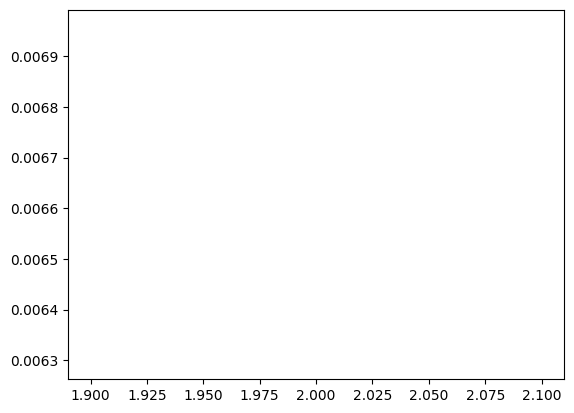

In [7]:
formatted_d=str(0)
FTLE = []
for i in range (20, 21):
    print("Processing "+str(i)+" clusters")
    n_clusters=i
    Fmap_path = clusters_path+str(n_clusters)+'_Fmap_cut.npy'
    labels_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels.npy'
    labels_disp_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_disp.npy'
    labels_reweighted_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_reweighted.npy'

    Fmap = np.load(Fmap_path)
    labels= np.load(labels_path)
    labels_disp = np.load(labels_disp_path)
    labels_reweighted = np.load(labels_reweighted_path)

    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    grid_labels = griddata((IC[0, :], IC[1, :]), labels_disp, (lon_grid,lat_grid), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels_disp, (lon_grid,lat_grid), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(fmap_mask,np.nan, borders_avg)
    borders_idx = np.where(borders_avg==1)
    borders_lon_rot = lon_grid[borders_idx]
    borders_lat_rot = lat_grid[borders_idx]
    FTLE.append(calculate_ftle_in_coordinates_ready(time, borders_lon_rot, borders_lat_rot, lon_grid, lat_grid, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid, NCores=NCores))

#np.save(clusters_path+"/2_100_FTLE.npy", FTLE)

mean_FTLE = []
idx = []
for i in range(0,len(FTLE)):
    mean_FTLE.append(np.mean(FTLE[i]))
    idx.append(2+i)

plt.plot(idx,mean_FTLE)

#plt.savefig(clusters_path+"/2_100_FTLE.png")

Processing 20 clusters
Processing 20 clusters


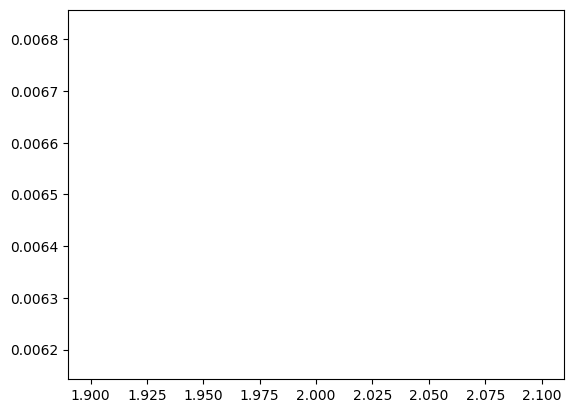

In [5]:
ftle_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap/FTLE_dx0.100_dy0.100_dt1.000_grid_ratio0.010/"
X_domain = np.load(ftle_path+"X_domain.npy")
Y_domain = np.load(ftle_path+"Y_domain.npy")
FTLE_field = np.load(ftle_path+"FTLE_"+str(year)+"_"+season+".npy")
Interpolant_FTLE = interpolant_unsteady_FTLE(X_domain, Y_domain, FTLE_field)



formatted_d=str(0)
FTLE = []
for i in range (20, 21):
    print("Processing "+str(i)+" clusters")
    n_clusters=i
    Fmap_path = clusters_path+str(n_clusters)+'_Fmap_cut.npy'
    labels_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels.npy'
    labels_disp_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_disp.npy'
    labels_reweighted_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_reweighted.npy'


    Fmap_path = clusters_path+str(n_clusters)+'_Fmap_cut.npy'
    labels_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels.npy'
    labels_disp_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_disp.npy'
    labels_reweighted_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_reweighted.npy'

    Fmap = np.load(Fmap_path)
    labels= np.load(labels_path)
    labels_disp = np.load(labels_disp_path)
    labels_reweighted = np.load(labels_reweighted_path)

    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    grid_labels = griddata((IC[0, :], IC[1, :]), labels_disp, (lon_grid,lat_grid), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels_disp, (lon_grid,lat_grid), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(fmap_mask,np.nan, borders_avg)
    borders_idx = np.where(borders_avg==1)
    borders_lon_rot = lon_grid[borders_idx]
    borders_lat_rot = lat_grid[borders_idx]
    FTLE.append(Interpolant_FTLE(borders_lat_rot, borders_lon_rot, grid=False))




#np.save(clusters_path+"/2_100_FTLE.npy", FTLE)

mean_FTLE = []
idx = []
for i in range(0,len(FTLE)):
    mean_FTLE.append(np.mean(FTLE[i]))
    idx.append(2+i)

plt.plot(idx,mean_FTLE)
#plt.savefig(clusters_path+"/2_100_FTLE.png")


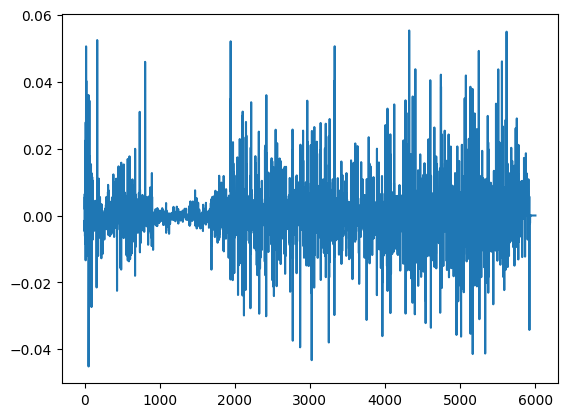

In [21]:
plt.plot(FTLE[0]-FTLE_interpol)

In [22]:
mean_FTLE

[np.float64(0.006627162058266702)]

In [23]:
np.mean(FTLE_interpol)

np.float64(0.006500028343325529)